# Causal Confusion in Imitation Learning
---

Behavioural cloning reduces policy learning to supervised learning. However, if the training procedure is unaware of the causal model the expert uses to interact with the environment, it can result in sub-optimal learned policies. In particular, accessing to more information can even yeild worse performance. In this notebook, we study this problem in a simple MountainCar environment. We follow the methodology described in [this paper](https://arxiv.org/pdf/1905.11979) to show a failure case and how one can avoid it.

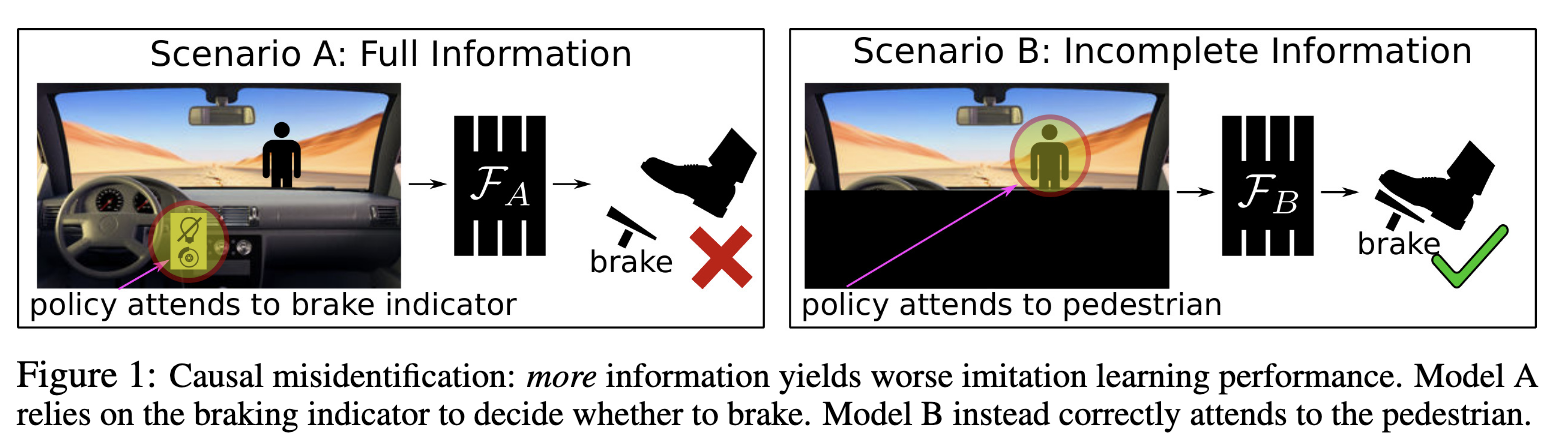

## Failure of Naive Imitation Learning in Confounded Settings

First, let's setup the environment and clone [this repo](https://github.com/pimdh/causal-confusion):

In [2]:
! git clone https://github.com/pimdh/causal-confusion --quiet

# Download the expert demonstration data
! wget -O expert_demonstrations.pkl https://github.com/csc2626/website/raw/refs/heads/main/labs/expert_demonstrations.pkl -q

We now load the expert data fro the mountaincar environment.

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
import gym
import torch
from tqdm import tqdm
import numpy as np

sys.path.append('causal-confusion/')
expert_dataset = torch.load("expert_demonstrations.pkl")

In [5]:
expert_dataset.states.shape

torch.Size([100075, 2])

We now show that, how naive behavioural cloning (BC) can result in failure when there is confounded data. We consider a simple confounding variable, where we append the action taken by the expert to the state. This way, a naive BC approach will pick up the action in each state, ignoring the velocity and position of the car. Hence, in an unconfounded setting, where the appended action is random, it will act randomly.

In [6]:
from ccil.utils.data import random_split, batch_cat, DataLoaderRepeater, Trajectory


class MountainCarStateEncoder:
    """
    Map batch from TransitionDataset or Trajectory into state vector.
    """
    def __init__(self, confounded):
        """
        :param confounded: Whether to append the expert action to the states
        (confounded) or to use random action (unconfounded).
        """
        self.random = not confounded

    def batch(self, batch):
        assert batch.states.shape[1] >= 2
        x = batch.states[:, -1, :]

        if self.random:
            prev_action = torch.randint(0, 3, (x.shape[0], 1), device=x.device, dtype=torch.float)
        else:
            prev_action = batch.actions[:, -2]

        return torch.cat([x.float(), prev_action.float()], 1)

    def step(self, state, trajectory):
        if trajectory and not self.random:
            prev_action = trajectory.actions[-1]
        else:
            prev_action = np.atleast_1d(np.random.randint(0, 3))
        x = np.concatenate([state, prev_action])
        return x


In [7]:
from typing import Literal
from datetime import datetime
from functools import partial

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from ccil.utils.utils import random_mask_from_state, mask_idx_to_mask
from ccil.utils.policy_runner import PolicyRunner, RandomMaskPolicyAgent, FixedMaskPolicyAgent
from ccil.utils.models import MLP

class SimplePolicy(nn.Module):
    # A Simple Behavioural Cloning Agent
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, state, mask):
        return self.net(state)


# The imitation learning loop
def naive_imitate(input_mode: Literal["unconfounded", "confounded"], num_samples: int, data_seed: int):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    dataset = torch.load("expert_demonstrations.pkl")
    train_dataset, test_dataset = random_split(dataset, [num_samples, num_samples], data_seed)

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=batch_cat),
        'test': DataLoader(test_dataset, batch_size=64, shuffle=True, collate_fn=batch_cat),
    }
    # So that 1 train epoch has fixed number of samples (500 batches) regardless of dataset size
    dataloaders['train_repeated'] = DataLoaderRepeater(dataloaders['train'], 500)


    policy_model = SimplePolicy(MLP([3, 50, 50, 3])).to(device)

    optimizer = torch.optim.Adam(policy_model.parameters())

    max_epochs = 10

    def criterion(x, y):
        return F.cross_entropy(x, y[:, 0])


    state_encoder = MountainCarStateEncoder(input_mode == 'confounded')

    for epoch in tqdm(range(max_epochs)):
          for batch in dataloaders['train_repeated']:
            x, y = state_encoder.batch(batch), batch.labels()
            x, y = x.to(device), y.to(device)

            mask = torch.randint(0, 2, size=x.shape, device=x.device)
            output = policy_model.forward(x, mask)
            loss = criterion(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          for batch in dataloaders['test']:
            x, y = state_encoder.batch(batch), batch.labels()
            x, y = x.to(device), y.to(device)
            mask = torch.randint(0, 2, size=x.shape, device=x.device)
            output = policy_model.forward(x, mask)
            acc = (output.argmax(1) == y[:, 0]).float().mean()
            loss = criterion(output, y)

          print(
          f"Epoch: {epoch} "
          f"loss={loss:.4f} "
          f"acc={acc:.4f}")


    print("Trained")

    # Run policies in environment
    env = gym.make("MountainCar-v0")
    agent = RandomMaskPolicyAgent(policy_model)
    runner = PolicyRunner(env, agent, state_encoder)
    trajectories = runner.run_num_episodes(20)

    print(f'Mean reward: {Trajectory.reward_sum_mean(trajectories)}')


In [8]:
naive_imitate('unconfounded', 300, 42)

 10%|█         | 1/10 [00:03<00:34,  3.80s/it]

Epoch: 0 loss=0.1207 acc=1.0000


 20%|██        | 2/10 [00:06<00:27,  3.43s/it]

Epoch: 1 loss=0.0791 acc=0.9773


 30%|███       | 3/10 [00:10<00:25,  3.59s/it]

Epoch: 2 loss=0.0864 acc=1.0000


 40%|████      | 4/10 [00:13<00:20,  3.39s/it]

Epoch: 3 loss=0.0490 acc=0.9773


 50%|█████     | 5/10 [00:16<00:16,  3.30s/it]

Epoch: 4 loss=0.1211 acc=0.9318


 60%|██████    | 6/10 [00:20<00:13,  3.31s/it]

Epoch: 5 loss=0.0701 acc=0.9773


 70%|███████   | 7/10 [00:23<00:10,  3.39s/it]

Epoch: 6 loss=0.0867 acc=0.9545


 80%|████████  | 8/10 [00:26<00:06,  3.31s/it]

Epoch: 7 loss=0.0660 acc=0.9773


 90%|█████████ | 9/10 [00:30<00:03,  3.26s/it]

Epoch: 8 loss=0.0876 acc=0.9773


100%|██████████| 10/10 [00:33<00:00,  3.38s/it]

Epoch: 9 loss=0.0466 acc=1.0000
Trained



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Mean reward: -130.65


In [9]:
naive_imitate('confounded', 300, 42)

 10%|█         | 1/10 [00:03<00:27,  3.10s/it]

Epoch: 0 loss=0.0211 acc=1.0000


 20%|██        | 2/10 [00:06<00:24,  3.11s/it]

Epoch: 1 loss=0.1007 acc=0.9545


 30%|███       | 3/10 [00:10<00:24,  3.44s/it]

Epoch: 2 loss=0.1427 acc=0.9318


 40%|████      | 4/10 [00:13<00:19,  3.30s/it]

Epoch: 3 loss=0.0554 acc=0.9773


 50%|█████     | 5/10 [00:16<00:16,  3.23s/it]

Epoch: 4 loss=0.0609 acc=0.9773


 60%|██████    | 6/10 [00:19<00:13,  3.28s/it]

Epoch: 5 loss=0.0606 acc=0.9773


 70%|███████   | 7/10 [00:23<00:10,  3.36s/it]

Epoch: 6 loss=0.0787 acc=0.9545


 80%|████████  | 8/10 [00:26<00:06,  3.26s/it]

Epoch: 7 loss=0.0204 acc=1.0000


 90%|█████████ | 9/10 [00:29<00:03,  3.22s/it]

Epoch: 8 loss=0.0645 acc=0.9545


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]

Epoch: 9 loss=0.1396 acc=0.9545
Trained


Mean reward: -200.0


As you can see, naive imitation in the confounded case results in smaller reward compared to the unconfounded case.

## Mitigating Causal Confusion with Uniform Intervention

To avoid such misidentification cases discussed above, a simple trick is to randomly mask part of the observed state and train it to imitate the expert. This way, in cases where the confounded part of the state is masked, the learner will pick up the causal signals and improve the inference performance.

In [10]:

class UniformMaskPolicy(nn.Module):
    # Uniformly masks the input state
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, state, mask):
        mask = mask.to(state).expand_as(state)
        x = torch.cat([state * mask, mask], 1)
        return self.net(x)

# The imitation learning loop
def uniform_imitate(input_mode: Literal["unconfounded", "confounded"], num_samples: int, data_seed: int):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    dataset = torch.load("expert_demonstrations.pkl")
    train_dataset, test_dataset = random_split(dataset, [num_samples, num_samples], data_seed)

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=batch_cat),
        'test': DataLoader(test_dataset, batch_size=64, shuffle=True, collate_fn=batch_cat),
    }
    # So that 1 train epoch has fixed number of samples (500 batches) regardless of dataset size
    dataloaders['train_repeated'] = DataLoaderRepeater(dataloaders['train'], 500)


    policy_model = UniformMaskPolicy(MLP([6, 50, 50, 50, 3])).to(device)
    max_epochs = 20

    optimizer = torch.optim.Adam(policy_model.parameters())


    def criterion(x, y):
        return F.cross_entropy(x, y[:, 0])


    state_encoder = MountainCarStateEncoder(input_mode == 'confounded')

    for epoch in tqdm(range(max_epochs)):
          for batch in dataloaders['train_repeated']:
            x, y = state_encoder.batch(batch), batch.labels()
            x, y = x.to(device), y.to(device)

            mask = torch.randint(0, 2, size=x.shape, device=x.device)
            output = policy_model.forward(x, mask)
            loss = criterion(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          for batch in dataloaders['test']:
            x, y = state_encoder.batch(batch), batch.labels()
            x, y = x.to(device), y.to(device)
            mask = torch.randint(0, 2, size=x.shape, device=x.device)
            output = policy_model.forward(x, mask)
            acc = (output.argmax(1) == y[:, 0]).float().mean()
            loss = criterion(output, y)

          print(
          f"Epoch: {epoch} "
          f"loss={loss:.4f} "
          f"acc={acc:.4f}")


    print("Trained")

    # Run policies in environment
    env = gym.make("MountainCar-v0")
    for mask_idx in range(8):
        agent = FixedMaskPolicyAgent(policy_model, mask_idx_to_mask(3, mask_idx))
        runner = PolicyRunner(env, agent, state_encoder)
        trajectories = runner.run_num_episodes(20)
        mask = mask_idx_to_mask(3, mask_idx).tolist()
        print(f'Mean reward mask {mask}: {Trajectory.reward_sum_mean(trajectories)}')

    print(f'Mean reward: {Trajectory.reward_sum_mean(trajectories)}')


In [11]:
uniform_imitate('unconfounded', 300, 42)

  5%|▌         | 1/20 [00:03<01:15,  3.96s/it]

Epoch: 0 loss=0.3575 acc=0.9318


 10%|█         | 2/20 [00:07<01:03,  3.50s/it]

Epoch: 1 loss=0.3377 acc=0.8182


 15%|█▌        | 3/20 [00:10<00:57,  3.39s/it]

Epoch: 2 loss=0.3421 acc=0.8182


 20%|██        | 4/20 [00:14<00:55,  3.47s/it]

Epoch: 3 loss=0.4574 acc=0.7500


 25%|██▌       | 5/20 [00:17<00:52,  3.51s/it]

Epoch: 4 loss=0.2549 acc=0.8864


 30%|███       | 6/20 [00:20<00:47,  3.42s/it]

Epoch: 5 loss=0.2733 acc=0.8409


 35%|███▌      | 7/20 [00:24<00:43,  3.35s/it]

Epoch: 6 loss=0.3254 acc=0.8182


 40%|████      | 8/20 [00:27<00:42,  3.52s/it]

Epoch: 7 loss=0.3063 acc=0.8636


 45%|████▌     | 9/20 [00:31<00:37,  3.42s/it]

Epoch: 8 loss=0.3986 acc=0.7955


 50%|█████     | 10/20 [00:34<00:33,  3.35s/it]

Epoch: 9 loss=0.4973 acc=0.7955


 55%|█████▌    | 11/20 [00:37<00:30,  3.35s/it]

Epoch: 10 loss=0.3057 acc=0.8409


 60%|██████    | 12/20 [00:41<00:27,  3.48s/it]

Epoch: 11 loss=0.2986 acc=0.8864


 65%|██████▌   | 13/20 [00:44<00:23,  3.40s/it]

Epoch: 12 loss=0.3311 acc=0.7727


 70%|███████   | 14/20 [00:47<00:20,  3.39s/it]

Epoch: 13 loss=0.5164 acc=0.8409


 75%|███████▌  | 15/20 [00:51<00:17,  3.55s/it]

Epoch: 14 loss=0.4141 acc=0.7500


 80%|████████  | 16/20 [00:55<00:13,  3.46s/it]

Epoch: 15 loss=0.3811 acc=0.7727


 85%|████████▌ | 17/20 [00:58<00:10,  3.39s/it]

Epoch: 16 loss=0.2962 acc=0.8182


 90%|█████████ | 18/20 [01:01<00:06,  3.33s/it]

Epoch: 17 loss=0.4934 acc=0.8182


 95%|█████████▌| 19/20 [01:05<00:03,  3.52s/it]

Epoch: 18 loss=0.2595 acc=0.8864


100%|██████████| 20/20 [01:08<00:00,  3.44s/it]

Epoch: 19 loss=0.3514 acc=0.8182
Trained


Mean reward mask [0, 0, 0]: -200.0
Mean reward mask [0, 0, 1]: -200.0
Mean reward mask [0, 1, 0]: -150.3
Mean reward mask [0, 1, 1]: -124.05
Mean reward mask [1, 0, 0]: -200.0
Mean reward mask [1, 0, 1]: -200.0
Mean reward mask [1, 1, 0]: -128.55
Mean reward mask [1, 1, 1]: -146.8
Mean reward: -146.8


In [12]:
uniform_imitate('confounded', 300, 42)

  5%|▌         | 1/20 [00:03<01:04,  3.41s/it]

Epoch: 0 loss=0.1516 acc=0.9773


 10%|█         | 2/20 [00:07<01:06,  3.69s/it]

Epoch: 1 loss=0.2637 acc=0.8864


 15%|█▌        | 3/20 [00:10<00:59,  3.50s/it]

Epoch: 2 loss=0.2886 acc=0.8409


 20%|██        | 4/20 [00:13<00:54,  3.42s/it]

Epoch: 3 loss=0.2543 acc=0.9545


 25%|██▌       | 5/20 [00:17<00:55,  3.67s/it]

Epoch: 4 loss=0.1865 acc=0.8864


 30%|███       | 6/20 [00:21<00:50,  3.60s/it]

Epoch: 5 loss=0.1451 acc=0.9545


 35%|███▌      | 7/20 [00:24<00:45,  3.48s/it]

Epoch: 6 loss=0.5080 acc=0.8636


 40%|████      | 8/20 [00:28<00:42,  3.50s/it]

Epoch: 7 loss=0.1705 acc=0.9091


 45%|████▌     | 9/20 [00:32<00:39,  3.63s/it]

Epoch: 8 loss=0.2136 acc=0.8864


 50%|█████     | 10/20 [00:35<00:35,  3.52s/it]

Epoch: 9 loss=0.1735 acc=0.9091


 55%|█████▌    | 11/20 [00:38<00:31,  3.45s/it]

Epoch: 10 loss=0.2967 acc=0.8864


 60%|██████    | 12/20 [00:42<00:28,  3.60s/it]

Epoch: 11 loss=0.2182 acc=0.9318


 65%|██████▌   | 13/20 [00:45<00:24,  3.49s/it]

Epoch: 12 loss=0.1189 acc=0.9545


 70%|███████   | 14/20 [00:49<00:20,  3.41s/it]

Epoch: 13 loss=0.1509 acc=0.9545


 75%|███████▌  | 15/20 [00:52<00:17,  3.50s/it]

Epoch: 14 loss=0.1787 acc=0.8864


 80%|████████  | 16/20 [00:56<00:14,  3.63s/it]

Epoch: 15 loss=0.2000 acc=0.8864


 85%|████████▌ | 17/20 [01:00<00:10,  3.54s/it]

Epoch: 16 loss=0.1465 acc=0.9545


 90%|█████████ | 18/20 [01:03<00:06,  3.49s/it]

Epoch: 17 loss=0.3306 acc=0.8636


 95%|█████████▌| 19/20 [01:07<00:03,  3.63s/it]

Epoch: 18 loss=0.5301 acc=0.8864


100%|██████████| 20/20 [01:10<00:00,  3.53s/it]

Epoch: 19 loss=0.1748 acc=0.9318
Trained


Mean reward mask [0, 0, 0]: -200.0
Mean reward mask [0, 0, 1]: -200.0
Mean reward mask [0, 1, 0]: -129.5
Mean reward mask [0, 1, 1]: -200.0
Mean reward mask [1, 0, 0]: -200.0
Mean reward mask [1, 0, 1]: -200.0
Mean reward mask [1, 1, 0]: -136.25
Mean reward mask [1, 1, 1]: -170.75
Mean reward: -170.75
